In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:

ROOT = Path.cwd().parent
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

In [3]:



from utils import get_logger
from data import load_ohlc_from_xlsx

logger = get_logger("trading_bot", log_file=str(ROOT/"logs"/"trading_bot.log"))

# --- Load predictions ---
pred_path = ROOT / "outputs" / "gold_predictions.csv"
df_pred = pd.read_csv(pred_path, parse_dates=["Date"])

# --- Load price series (Gold) ---
XLSX = ROOT / "dataset_train.xlsx"
df_px = load_ohlc_from_xlsx(str(XLSX), sheet_name="Gold")  # Date, Open, High, Low, Close
df_px["Date"] = pd.to_datetime(df_px["Date"])

# Merge
df = df_px.merge(df_pred[["Date", "y_pred"]], on="Date", how="inner").sort_values("Date").reset_index(drop=True)
logger.info("Merged rows=%d", len(df))

# --- Strategy parameters ---
threshold = 0.7
horizon = 20
fee_bps = 2.0  # 2 bps per trade side (example)
fee = fee_bps / 10_000.0

# --- Build signals ---
# signal at t -> executed at t+1 open (so we shift by 1)
raw_signal = np.where(df["y_pred"] > threshold, 1,
              np.where(df["y_pred"] < -threshold, -1, 0))

df["signal_t"] = raw_signal
df["position"] = pd.Series(raw_signal).shift(1).fillna(0).astype(int)

# --- Compute realized forward return over holding horizon using Open prices ---
# Enter at Open(t), exit at Open(t+horizon)
entry = df["Open"]
exit_ = df["Open"].shift(-horizon)

df["fwd_ret_h"] = (exit_ / entry) - 1.0

# Strategy return
df["gross_ret"] = df["position"] * df["fwd_ret_h"]

# Fees: charge when position changes (entry/exit). Simplified:
# whenever position != previous_position, pay fee
pos_prev = df["position"].shift(1).fillna(0)
trade_event = (df["position"] != pos_prev).astype(int)
df["fee"] = trade_event * fee

df["net_ret"] = df["gross_ret"] - df["fee"]

# Drop rows where we don't have a full horizon return
df_bt = df.dropna(subset=["fwd_ret_h"]).copy()

# Equity curve
df_bt["equity"] = (1 + df_bt["net_ret"].fillna(0)).cumprod()

# Basic metrics
mean = df_bt["net_ret"].mean()
std = df_bt["net_ret"].std(ddof=0)
sharpe_proxy = mean / (std + 1e-12)

max_dd = (df_bt["equity"] / df_bt["equity"].cummax() - 1).min()

logger.info("Trades=%d | Coverage=%.2f%%", trade_event.sum(), 100*(df_bt["position"] != 0).mean())
logger.info("Mean net ret=%.6f | Std=%.6f | Sharpe proxy=%.3f | MaxDD=%.2f%%",
            mean, std, sharpe_proxy, 100*max_dd)

df_bt[["Date","Open","Close","y_pred","signal_t","position","fwd_ret_h","net_ret","equity"]].tail()


2025-12-19 09:35:08,498 | INFO | data | Loading sheet=Gold from c:\Users\fayca\Downloads\hackathon_gold_project\hackathon_gold_project\dataset_train.xlsx
2025-12-19 09:35:12,971 | INFO | data | Loaded 11340 rows, columns=['Date', 'Open', 'High', 'Low', 'Close', 'smavg_50', 'smavg_100', 'smavg_240']
2025-12-19 09:35:13,001 | INFO | trading_bot | Merged rows=2217
2025-12-19 09:35:13,019 | INFO | trading_bot | Trades=4 | Coverage=0.14%
2025-12-19 09:35:13,020 | INFO | trading_bot | Mean net ret=0.000149 | Std=0.004232 | Sharpe proxy=0.035 | MaxDD=-0.02%


,Date,Open,Close,y_pred,signal_t,position,fwd_ret_h,net_ret,equity
2192,2018-10-30,1229.42,1222.93,0.234066,0,0,-0.005710,-0.0,1.363472
2193,2018-10-31,1222.93,1214.76,0.220012,0,0,-0.006444,-0.0,1.363472
2194,2018-11-01,1214.76,1233.43,0.234889,0,0,0.005343,0.0,1.363472
2195,2018-11-02,1233.43,1232.89,0.207573,0,0,-0.007451,-0.0,1.363472
2196,2018-11-05,1233.25,1231.49,0.158090,0,0,-0.009365,-0.0,1.363472


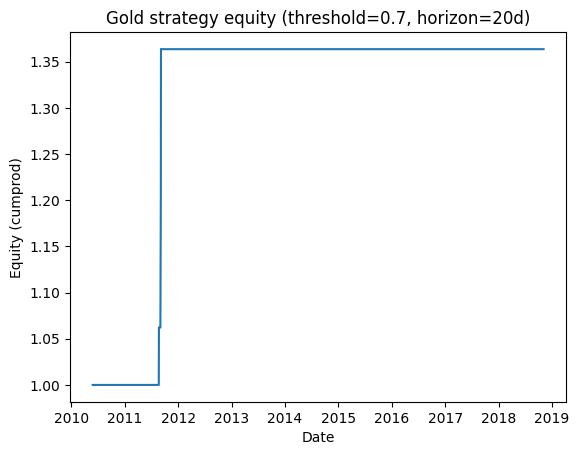

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_bt["Date"], df_bt["equity"])
plt.title(f"Gold strategy equity (threshold={threshold}, horizon={horizon}d)")
plt.xlabel("Date")
plt.ylabel("Equity (cumprod)")
plt.show()
